SyntaxError: invalid syntax (4148572746.py, line 1)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform, warp, resize
from skimage.util import random_noise
from skimage import color, filters, measure, morphology
from scipy.signal import wiener
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [6]:


# ---- Step 1: Load and Prepare MNIST Digits ----
print("Loading MNIST dataset...")
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = y.astype(str)
print("Loading compleated")


Loading MNIST dataset...
Loading compleated


In [12]:


# ---- Step 2: Create Synthetic License Plate ----
def create_plate(digits):
    plate = np.hstack([resize(X_train[y_train == d][0].reshape(28, 28), (28, 28)) for d in digits])
    return plate

# ---- Step 3: Apply Affine Transformation and Noise ----
def simulate_affine_noise(image):
    tform = AffineTransform(shear=0.2, rotation=0.1, scale=(1, 1))
    warped = warp(image, tform.inverse)
   # noisy = random_noise(warped, mode='gaussian', var=0.001)
    return warped

# ---- Step 4: Denoising with Wiener Filter ----
def denoise(image):
    return wiener(image)

# ---- Step 5: Segment Digits ----
def segment_digits(image):
    thresh = filters.threshold_otsu(image)
    binary = image < thresh
    cleared = morphology.remove_small_objects(binary, min_size=30)
    label_image = measure.label(cleared)
    regions = measure.regionprops(label_image)

    digits = []
    for region in sorted(regions, key=lambda r: r.bbox[1]):  # sort left to right
        minr, minc, maxr, maxc = region.bbox
        digit = image[minr:maxr, minc:maxc]
        digit_resized = resize(digit, (28, 28), anti_aliasing=True)
        digits.append(digit_resized.flatten())
    return digits

In [11]:
# Reduce dataset size for performance
X_train, _, y_train, _ = train_test_split(X, y, train_size=6000, stratify=y, random_state=42)

clf = SVC(kernel='rbf', gamma=0.05)
clf.fit(X_train, y_train)

SVC(gamma=0.05)

/home/mkros/VENV/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1657: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/home/mkros/VENV/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1657: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


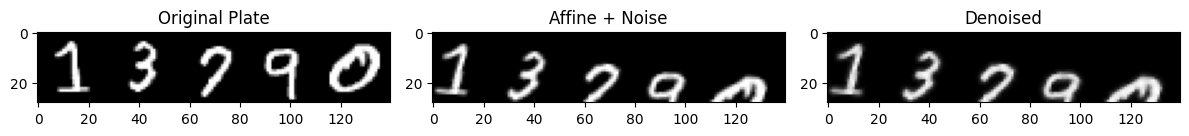

Ground truth: 13790
Predicted   : 111


In [13]:

# ---- Step 6: Full Pipeline ----
plate_digits = ['1', '3', '7', '9', '0']
original_plate = create_plate(plate_digits)
affine_noisy = simulate_affine_noise(original_plate)
denoised = denoise(affine_noisy)

segments = segment_digits(denoised)
predictions = clf.predict(segments)

# ---- Step 7: Visualization ----
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Plate")
plt.imshow(original_plate, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Affine + Noise")
plt.imshow(affine_noisy, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Denoised")
plt.imshow(denoised, cmap='gray')
plt.tight_layout()
plt.show()

print("Ground truth:", ''.join(plate_digits))
print("Predicted   :", ''.join(predictions))

In [14]:
type(segments)

list

In [15]:
type(segments[0])

numpy.ndarray

TypeError: Invalid shape (784,) for image data

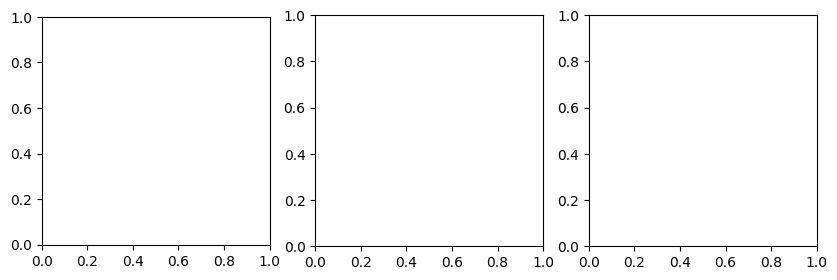

In [19]:
fig, axes = plt.subplots(1, len(digit_image), figsize=(10, 3))
for ax, img in zip(axes, digit_images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle("Segmented and Resized Digits (28x28)")
plt.show()